In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc as misc 
from scipy.signal import resample

import optimusprimal.primal_dual as primal_dual
import optimusprimal.grad_operators as grad_operators
import optimusprimal.linear_operators as linear_operators
import optimusprimal.prox_operators as prox_operators

import optimusprimal as optpr
import ProxNest as prn
import ProxNest.operators as operators

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('dark_background')
plt.rcParams["font.family"] = "serif"

In [2]:
# Auxiliary functions

def eval_snr(x, x_est):
    if np.array_equal(x, x_est):
        return 0
    num = np.sqrt(np.sum(np.abs(x) ** 2))
    den = np.sqrt(np.sum(np.abs(x - x_est) ** 2))
    return round(20*np.log10(num/den), 2)



First, we need to define some heuristics for the solver, these include:

      - tol: convergence criteria for the iterations
      - iter: maximum number of iterations
      - update_iter: iterations between logging iteration diagnostics
      - record_iters: whether to record the full diagnostic information



In [3]:
options = {"tol": 1e-5, "iter": 5000, "update_iter": 50, "record_iters": False}

In [5]:
# Load Image
dim = 64
repo_dir = '/Users/tliaudat/Documents/postdoc/github/proxnest'
ground_truth = np.load(repo_dir + '/data/galaxy_image_{}.npy'.format(dim))

# Normalise magnitude
ground_truth -= np.nanmin(ground_truth)
ground_truth /= np.nanmax(ground_truth)
ground_truth[ground_truth<0] = 0

x = ground_truth


In [6]:
# A mock radio imaging forward model with half of the Fourier coefficients masked
phi = operators.sensing_operators.MaskedFourier(dim, 0.5)



In [7]:
# Simulate mock noisy observations y
y = phi.dir_op(ground_truth)
ISNR = 25
sigma = np.sqrt(np.mean(np.abs(y)**2)) * 10**(-ISNR/20)
n = np.random.normal(0, sigma, y.shape)

# Simulate mock noisy observations
y += n



## CRR-based UQ

### Compute the MAP


In [8]:
import torch
from convex_reg import utils
from tqdm import tqdm

gpu = False

if gpu:
    device = 'cuda:0'
    torch.set_grad_enabled(False)
    torch.set_num_threads(4)
else:
    device = 'cpu'
    

In [9]:
sigma_training = 25
t = 5
dir_name = '/Users/tliaudat/Documents/postdoc/github/convex_ridge_regularizers/trained_models/'
exp_name = f'Sigma_{sigma_training}_t_{t}/'
model = utils.load_model(dir_name+exp_name, device, gpu=gpu)

print(f'Numbers of parameters before prunning: {model.num_params}')
model.prune()
print(f'Numbers of parameters after prunning: {model.num_params}')


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 - linear_spline activation functions
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
Numbers of parameters before prunning: 13610
---------------------
 PRUNNING 
 Found 22 filters with non-vanishing potential functions
---------------------
Numbers of parameters after prunning: 4183


In [10]:

myType = torch.float32

# y_torch = torch.tensor(y, device=device, dtype=myType, requires_grad=False).reshape((1,1) + y.shape) # .to(torch.float32)
x_torch = torch.tensor(x, device=device, dtype=myType, requires_grad=False).reshape((1,1) + x.shape) 

# Define the grad
g = optpr.grad_operators.l2_norm(sigma, y, phi)
g.beta = 1.0 / sigma ** 2

# Real prox 
f = optpr.prox_operators.real_prox()
# f = None


In [11]:
# Gradient descent

# phi.adj_op()
# phi.dir_op()

x_init = np.real(phi.adj_op(y))
x_init_torch = torch.tensor(x_init, device=device, dtype=myType, requires_grad=False).reshape((1,1) + x_init.shape) 

# optimization settings
tol = 1e-4
n_iter_max = 1500
lmbd = 3 # 4.5 # 6
mu = 20

# stepsize rule
L = model.L
alpha = 1. / ( 1. + g.beta + mu * lmbd * L)

# initialization
x_hat = torch.clone(x_init_torch)
z = torch.clone(x_init_torch)
t = 1


In [12]:
for i in tqdm(range(options['iter'])):
    x_hat_old = torch.clone(x_hat)
    # grad = g.grad(z.squeeze()) +  lmbd * model(mu * z)
    x_hat = z - alpha *(torch.tensor(g.grad(z.detach().cpu().squeeze()), device=device, dtype=myType).reshape((1,1) + x_init.shape) + lmbd * model(mu * z))
    x_hat =  torch.real(x_hat)
    # possible constraint, AGD becomes FISTA
    # e.g. if positivity
    # x = torch.clamp(x, 0, None)
    
    t_old = t 
    t = 0.5 * (1 + np.sqrt(1 + 4*t**2))
    z = x_hat + (t_old - 1)/t * (x_hat - x_hat_old)

    # relative change of norm for terminating
    res = (torch.norm(x_hat_old - x_hat)/torch.norm(x_hat_old)).item()
    if res < tol:
        break


  0%|          | 0/5000 [00:00<?, ?it/s]<ipython-input-12-fd08ec712d45>:4: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525473998/work/aten/src/ATen/native/Copy.cpp:250.)
  x_hat = z - alpha *(torch.tensor(g.grad(z.detach().cpu().squeeze()), device=device, dtype=myType).reshape((1,1) + x_init.shape) + lmbd * model(mu * z))
 29%|██▉       | 1453/5000 [00:08<00:20, 177.23it/s]


-----------------------
Updating spline coefficients for the reg cost
 (the gradient-step model is trained and intergration is required to compute the regularization cost)
-----------------------


<ipython-input-13-4f0fd10070e4>:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr(ground_truth, images[i]),
/Users/tliaudat/miniconda3/envs/convex_uq/lib/python3.9/site-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


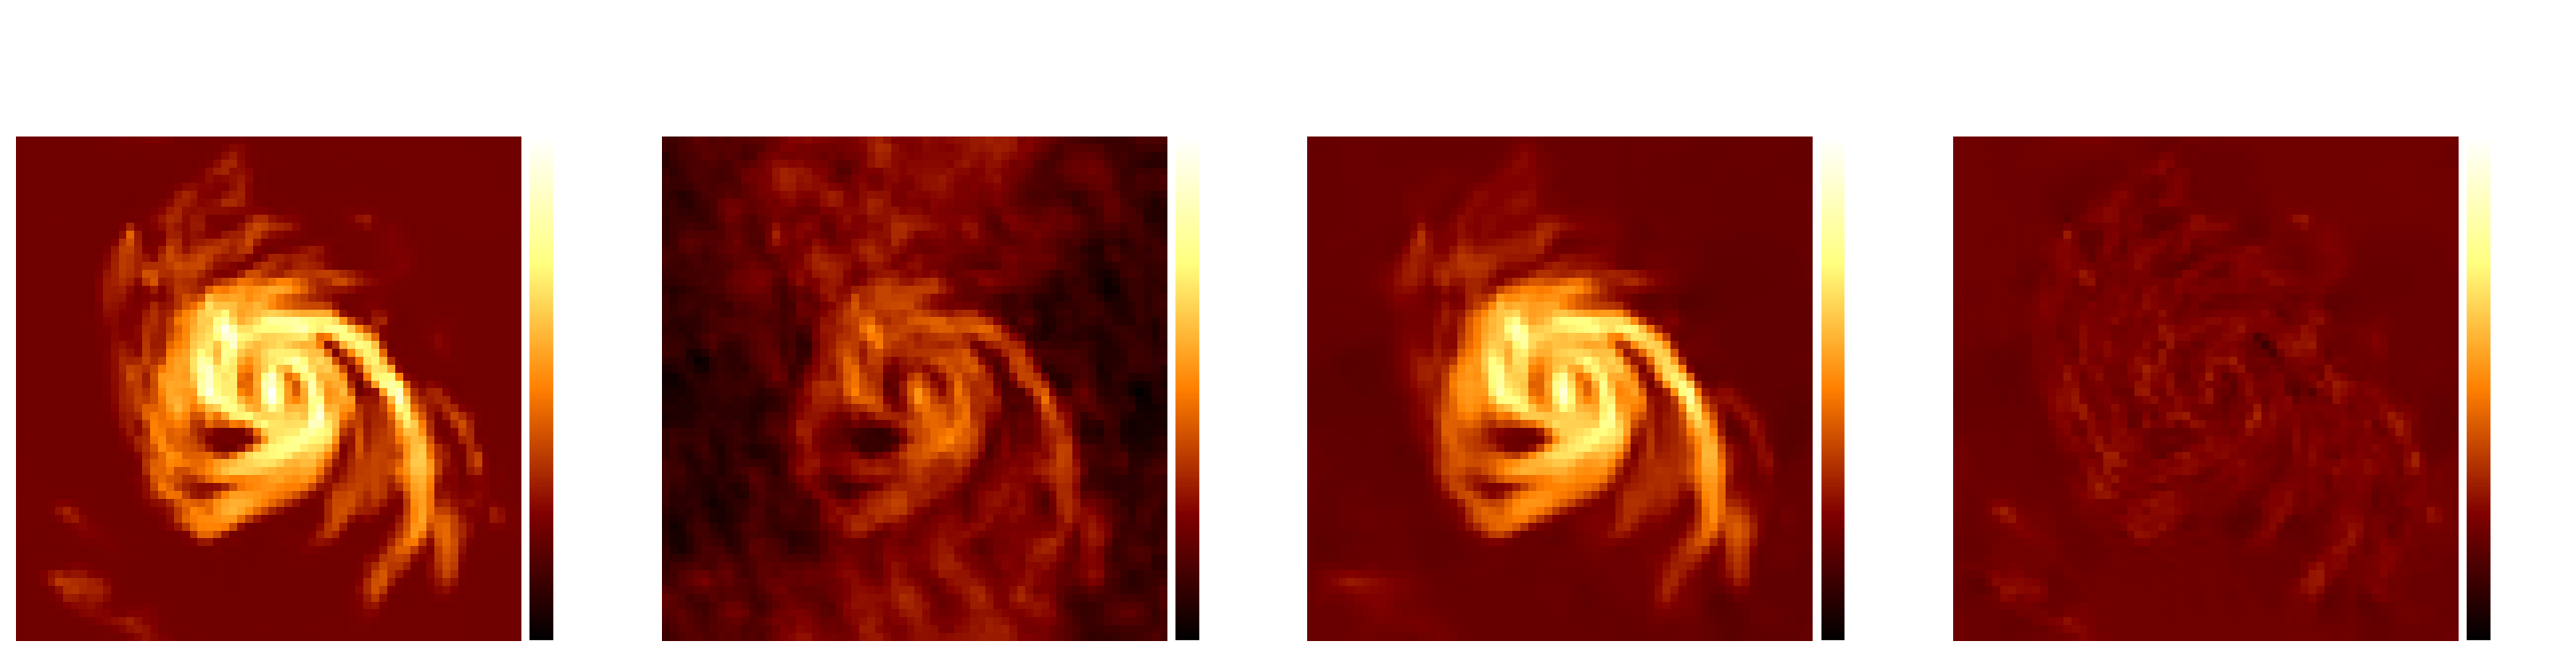

In [13]:
x_hat_np = x_hat.detach().cpu().squeeze().numpy()

images = [x, x_init, x_hat_np, x-np.abs(x_hat_np)]
images_torch = [x_torch, x_init_torch, x_hat, x_torch-x_hat]
labels = ["Truth", "Dirty", "Reconstruction", "Residual (x - x^hat)"]

fig, axs = plt.subplots(1,4, figsize=(20,8), dpi=200)
for i in range(4):
    im = axs[i].imshow(images[i], cmap='afmhot', vmax=np.nanmax(images), vmin=np.nanmin(images))
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    if i == 0:
        stats_str = '\nRegCost {:.3f}'.format(model.cost(mu * images_torch[i])[0].item())
    if i > 0:   
        stats_str = '\n(PSNR: {:.2f}, SNR: {:.2f},\nSSIM: {:.2f}, RegCost: {:.3f})'.format(
            psnr(ground_truth, images[i]),
            eval_snr(x, images[i]),
            ssim(ground_truth, images[i]),
            model.cost(mu * images_torch[i])[0].item(),
            )
    labels[i] += stats_str
    axs[i].set_title(labels[i], fontsize=16)
    axs[i].axis('off')
plt.show()

### Compute HPD region

In [14]:
alpha = 0.01
N = x_hat_np.size
tau_alpha = np.sqrt(16*np.log(3/alpha))

prior_fun = lambda model, x_hat, mu, lambda_param : (lambda_param/mu) * model.cost(mu*torch.tensor(x_hat, device=device, dtype=myType, requires_grad=False))

# gamma_alpha = g.fun(x_hat_np) + (lmbd/mu) * model.cost(mu*torch.tensor(x_hat, device=device, dtype=myType, requires_grad=False)).detach().cpu().squeeze().numpy() + tau_alpha*np.sqrt(N) + N

gamma_alpha = g.fun(x_hat_np) + (lmbd/mu) * model.cost(mu * x_hat.clone().detach().requires_grad_(False)).detach().cpu().squeeze().numpy() + tau_alpha*np.sqrt(N) + N


loss_fun = lambda x_map : g.fun(x_map) + (lmbd/mu) * model.cost(mu * x_hat.clone().detach().requires_grad_(False)).detach().cpu().squeeze().numpy()


In [15]:
alpha = 0.01
np.sqrt(16*np.log(3/alpha))

9.553037192144664

In [16]:

print(
    'f(x_map): ', g.fun(x_hat_np),
    ', g(x_map): ', (lmbd/mu) * model.cost(mu * x_hat.clone().detach().requires_grad_(False)).detach().cpu().squeeze().numpy(),
    'tau_alpha*np.sqrt(N): ', tau_alpha*np.sqrt(N),
    'N: ', N,
)
print('N: ', N)
print('tau_alpha: ', tau_alpha)
print('gamma_alpha: ', gamma_alpha)

f(x_map):  1990.8240961455654 , g(x_map):  2.9058488845825194 tau_alpha*np.sqrt(N):  611.3943802972585 N:  4096
N:  4096
tau_alpha:  9.553037192144664
gamma_alpha:  6701.124325327406


In [17]:
if dim==256:

    error_p_20, error_m_20, mean_20 = optpr.map_uncertainty.create_local_credible_interval(
        x_sol=x_hat_np,
        region_size=20,
        function=loss_fun,
        bound=gamma_alpha,
        iters=400,
        tol=1e-4,
        bottom=-1.,
        top=2.,
    )
    error_length_20 = error_p_20 - error_m_20

In [18]:
if dim==256:
    vmin = np.min((x, x_init, x_hat_np))
    vmax = np.max((x, x_init, x_hat_np))

    plt.figure(figsize=(24,4))
    plt.subplot(151)
    plt.imshow(x, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Ground truth')
    plt.subplot(152)
    plt.imshow(x_init, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Dirty')
    plt.subplot(153)
    plt.imshow(x_hat_np, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('MAP estimator')
    plt.subplot(154)
    plt.imshow(error_length_20, cmap='afmhot', vmin=0, vmax=vmax);plt.colorbar();plt.title('Length interval')
    plt.subplot(155)
    plt.imshow(mean_20, cmap='afmhot');plt.colorbar();plt.title('Mean')
    plt.savefig('./figs/gal_256_CCR-reg_superpix_20.pdf')
    plt.show()


In [23]:

error_p_2, error_m_2, mean_2 = optpr.map_uncertainty.create_local_credible_interval(
    x_sol=x_hat_np,
    region_size=2,
    function=loss_fun,
    bound=gamma_alpha,
    iters=200,
    tol=1e-4,
    bottom=-0.5,
    top=0.5,
)
error_length_2 = error_p_2 - error_m_2



2023-02-13 16:59:47,329 - Optimus Primal - INFO - Calculating credible interval for (64, 64) superpxiels.
2023-02-13 16:59:47,425 - Optimus Primal - INFO - [Bisection Method] There is no root in this range.
2023-02-13 16:59:47,526 - Optimus Primal - INFO - [Bisection Method] There is no root in this range.
2023-02-13 16:59:47,527 - Optimus Primal - INFO - [Credible Interval] (0, 0) has interval (0.0, 0.0) with sum -0.0035685685
2023-02-13 16:59:47,544 - Optimus Primal - INFO - [Bisection Method] There is no root in this range.
2023-02-13 16:59:47,558 - Optimus Primal - INFO - [Bisection Method] There is no root in this range.
2023-02-13 16:59:47,560 - Optimus Primal - INFO - [Credible Interval] (0, 1) has interval (0.0, 0.0) with sum -0.0014370175
2023-02-13 16:59:47,572 - Optimus Primal - INFO - [Bisection Method] There is no root in this range.
2023-02-13 16:59:47,583 - Optimus Primal - INFO - [Bisection Method] There is no root in this range.
2023-02-13 16:59:47,584 - Optimus Primal

In [21]:
error_p_4, error_m_4, mean_4 = optpr.map_uncertainty.create_local_credible_interval(
    x_sol=x_hat_np,
    region_size=4,
    function=loss_fun,
    bound=gamma_alpha,
    iters=400,
    tol=1e-4,
    bottom=-0.5,
    top=0.5,
)
error_length_4 = error_p_4 - error_m_4


error_p_8, error_m_8, mean_8 = optpr.map_uncertainty.create_local_credible_interval(
    x_sol=x_hat_np,
    region_size=8,
    function=loss_fun,
    bound=gamma_alpha,
    iters=400,
    tol=1e-4,
    bottom=-0.5,
    top=0.5,
)
error_length_8 = error_p_8 - error_m_8

2023-02-13 16:55:00,651 - Optimus Primal - INFO - Calculating credible interval for (64, 64) superpxiels.
2023-02-13 16:55:01,077 - Optimus Primal - INFO - [Credible Interval] (0, 0) has interval (-0.36397678405046463, 0.34594253450632095) with sum -0.014135567
2023-02-13 16:55:01,441 - Optimus Primal - INFO - [Credible Interval] (0, 1) has interval (-0.3408419117331505, 0.36918725073337555) with sum 0.07279779
2023-02-13 16:55:01,955 - Optimus Primal - INFO - [Credible Interval] (0, 2) has interval (-0.35246239602565765, 0.357089526951313) with sum 0.044956695
2023-02-13 16:55:02,370 - Optimus Primal - INFO - [Credible Interval] (0, 3) has interval (-0.3576044291257858, 0.35213666409254074) with sum 0.029964993
2023-02-13 16:55:02,796 - Optimus Primal - INFO - [Credible Interval] (0, 4) has interval (-0.3524658977985382, 0.35722414404153824) with sum 0.04517688
2023-02-13 16:55:03,131 - Optimus Primal - INFO - [Credible Interval] (0, 5) has interval (-0.3546218201518059, 0.35511685162

In [64]:
# error_length_4_it_200 = np.copy(error_length_4)
# mean_4_it_200 = np.copy(mean_4)

In [118]:
x.shape

(64, 64)

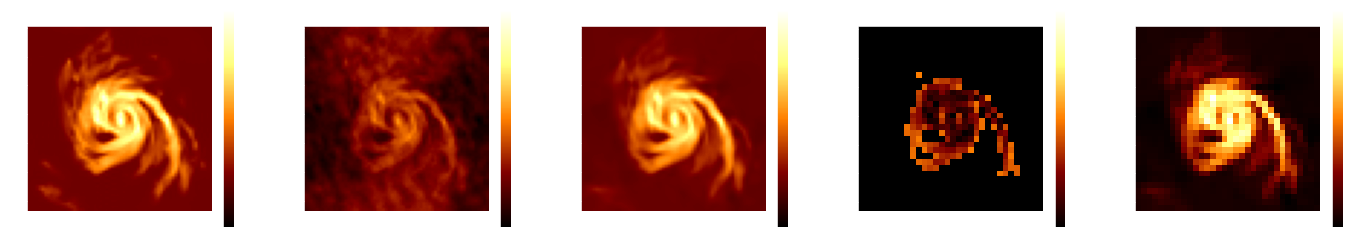

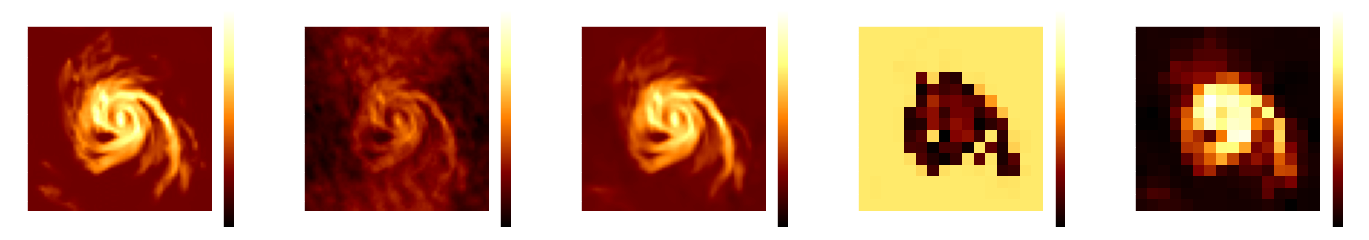

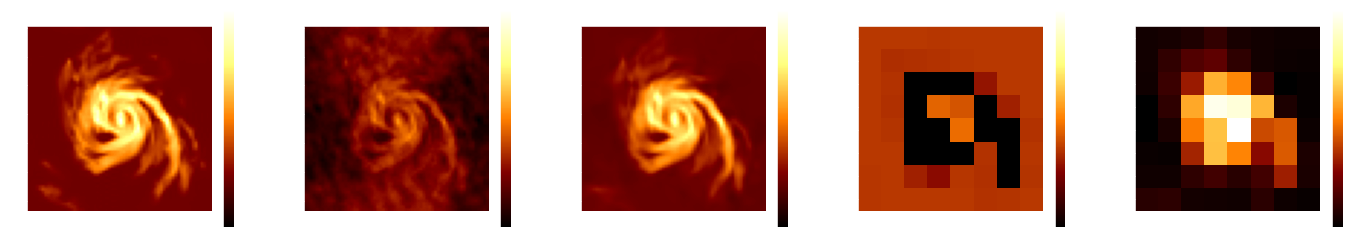

In [24]:

vmin = np.min((x, x_init, x_hat_np))
vmax = np.max((x, x_init, x_hat_np))

plt.figure(figsize=(24,4))
plt.subplot(151)
plt.imshow(x, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Ground truth')
plt.subplot(152)
plt.imshow(x_init, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Dirty')
plt.subplot(153)
plt.imshow(x_hat_np, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('MAP estimator')
plt.subplot(154)
plt.imshow(error_length_2, cmap='afmhot', vmin=0, vmax=vmax);plt.colorbar();plt.title('Length interval')
plt.subplot(155)
plt.imshow(mean_2, cmap='afmhot');plt.colorbar();plt.title('Mean')
plt.savefig('./figs/gal_64_CCR-reg_superpix_2_range_05_-05.pdf')
plt.show()

plt.figure(figsize=(24,4))
plt.subplot(151)
plt.imshow(x, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Ground truth')
plt.subplot(152)
plt.imshow(x_init, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Dirty')
plt.subplot(153)
plt.imshow(x_hat_np, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('MAP estimator')
plt.subplot(154)
plt.imshow(error_length_4, cmap='afmhot', vmin=0, vmax=vmax);plt.colorbar();plt.title('Length interval')
plt.subplot(155)
plt.imshow(mean_4, cmap='afmhot');plt.colorbar();plt.title('Mean')
plt.savefig('./figs/gal_64_CCR-reg_superpix_4_range_05_-05.pdf')
plt.show()

plt.figure(figsize=(24,4))
plt.subplot(151)
plt.imshow(x, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Ground truth')
plt.subplot(152)
plt.imshow(x_init, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Dirty')
plt.subplot(153)
plt.imshow(x_hat_np, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('MAP estimator')
plt.subplot(154)
plt.imshow(error_length_8, cmap='afmhot', vmin=0, vmax=vmax);plt.colorbar();plt.title('Length interval')
plt.subplot(155)
plt.imshow(mean_8, cmap='afmhot');plt.colorbar();plt.title('Mean')
plt.savefig('./figs/gal_64_CCR-reg_superpix_8_range_05_-05.pdf')
plt.show()

